## Title
Feature Engineering

### By:
Juan Gómez

### Date:
2024-05-16

### Description:

Clean and prepare message data from the Yelp dataset for the classification model. Remove duplicates, fix missing values, and keep useful columns only.


## Import  libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Load data

In [2]:
from pathlib import Path

pd.set_option("display.max_columns", None)

BASE_DIR = Path.cwd().resolve().parents[1]

In [3]:
df = pd.read_parquet(
    BASE_DIR / "data/02_intermediate/data_message_classifier_interm.parquet"
)

In [4]:
df.sample(5)

,review_id,stars,useful,funny,cool,text,date,review_count,useful_user,funny_user,cool_user,elite,fans,average_stars,address,city,state,stars_user,is_open,categories
519617,03WBta_eSvue0tu9H1id1A,5,1,0,1,Really love this place. Been here multiple tim...,2019-10-14 03:27:04,8,11,5,4,,0,4.13,1709 E Passyunk Ave,Philadelphia,PA,4.5,True,"Nightlife, Bars, Restaurants, Wine Bars, Tapas..."
890031,N70PvORXMN7dWEesA-k4dA,5,2,2,2,Stopped into this tiny shop twice over a long ...,2018-10-04 14:26:04,281,606,295,405,"2015,2016,2017",21,4.00,627 St Peter St,New Orleans,LA,4.5,True,"Food, Bars, Coffee & Tea, Nightlife"
439550,Mq_sFpcdNJDYKsei6l0T7A,5,1,0,0,"Besides great service, that wonderful man at t...",2020-01-15 20:59:07,27,32,12,4,,1,2.97,5883 Lower York Rd,Lahaska,PA,3.5,True,"Hotels, Event Planning & Services, Hotels & Tr..."
681313,aFZah2gfJMJP_EDzsF73yw,3,2,0,0,The decor and ambiance was pretty nice and def...,2019-05-05 02:33:28,169,108,14,39,"2019,20,20,2021",2,4.24,256 E Congress St,Tucson,AZ,3.5,False,"Nightlife, Bars, Mexican, Restaurants"
1489567,8n23cAtcTmnuo8u5uvD9LQ,5,2,0,0,They have not once gotten my order wrong and t...,2017-01-25 08:39:28,94,53,16,8,"2017,2018",2,4.59,3720 S Lindbergh Blvd,Sunset Hills,MO,3.5,True,"Food, Juice Bars & Smoothies, Health Markets, ..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499992 entries, 0 to 1499991
Data columns (total 20 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   review_id      1499992 non-null  string        
 1   stars          1499992 non-null  int64         
 2   useful         1499992 non-null  int32         
 3   funny          1499992 non-null  int32         
 4   cool           1499992 non-null  int32         
 5   text           1499992 non-null  string        
 6   date           1499992 non-null  datetime64[ns]
 7   review_count   1499992 non-null  int32         
 8   useful_user    1499992 non-null  int32         
 9   funny_user     1499992 non-null  int32         
 10  cool_user      1499992 non-null  int32         
 11  elite          1499992 non-null  category      
 12  fans           1499992 non-null  int32         
 13  average_stars  1499992 non-null  float64       
 14  address        1499992 non-null  s

In [6]:
df.shape

(1499992, 20)

# Data Preparation

### Type Columns

In [7]:
cols_categoric = df.select_dtypes(include=["category"]).columns.tolist()

In [8]:
cols_num = df.select_dtypes(include=["int32", "float64"]).columns.tolist()

In [9]:
cols_boolean = df.select_dtypes(include=["bool"]).columns.tolist()

In [10]:
cols_string = df.select_dtypes(include=["string"]).columns.tolist()

In [11]:
col_date = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()

### Remove duplicates

In [12]:
df_drop_duplicates = df.drop_duplicates(subset=["review_id"])

In [13]:
print(df_drop_duplicates.duplicated(subset=["review_id"]).sum())

0


### Missing values

In [14]:
df.isna().sum()

review_id          0
stars              0
useful             0
funny              0
cool               0
text               0
date               0
review_count       0
useful_user        0
funny_user         0
cool_user          0
elite              0
fans               0
average_stars      0
address            0
city               0
state              0
stars_user         0
is_open            0
categories       209
dtype: int64

### Handle outliers

In [15]:
for col in cols_num:
    q1 = df_drop_duplicates[col].quantile(0.25)
    q3 = df_drop_duplicates[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df_drop_duplicates[
        (df_drop_duplicates[col] < lower) | (df_drop_duplicates[col] > upper)
    ]
    print(f"{col}: {len(outliers)} outliers")

useful: 224934 outliers
funny: 367903 outliers
cool: 137473 outliers
review_count: 166743 outliers
useful_user: 225394 outliers
funny_user: 238980 outliers
cool_user: 236434 outliers
fans: 217120 outliers
average_stars: 105008 outliers
stars_user: 41591 outliers


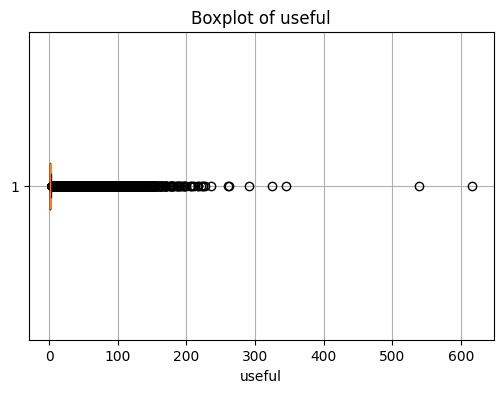

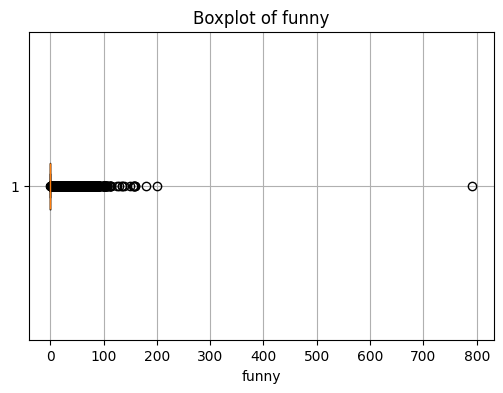

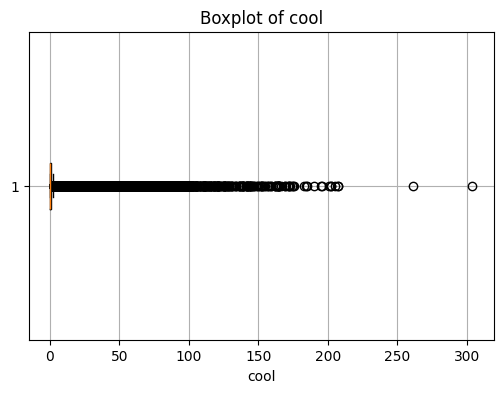

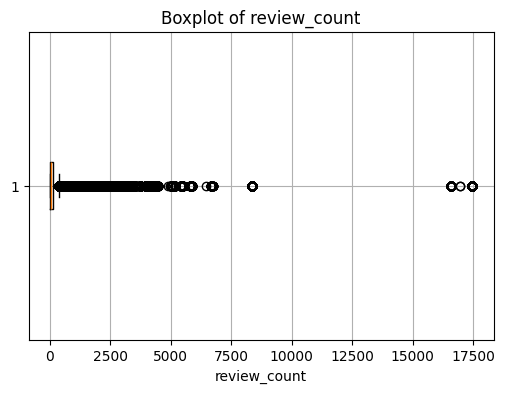

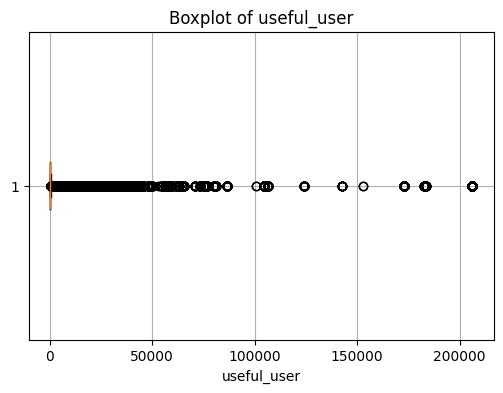

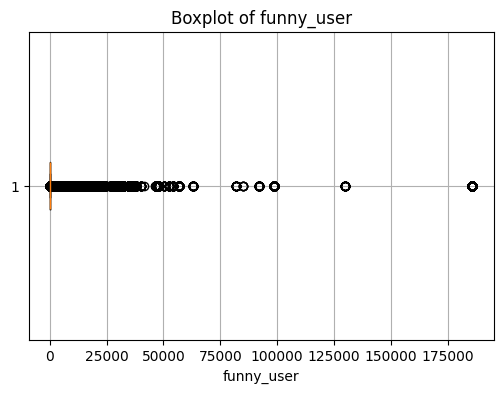

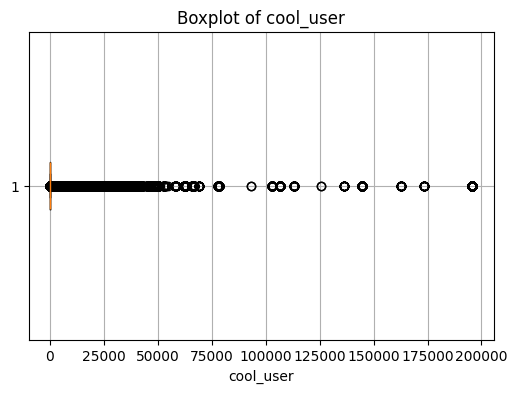

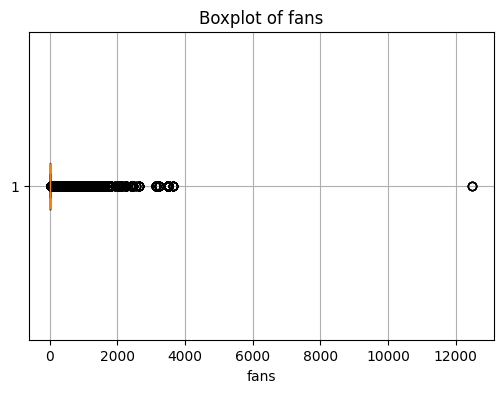

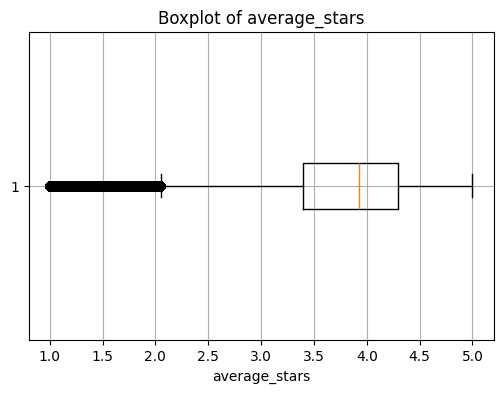

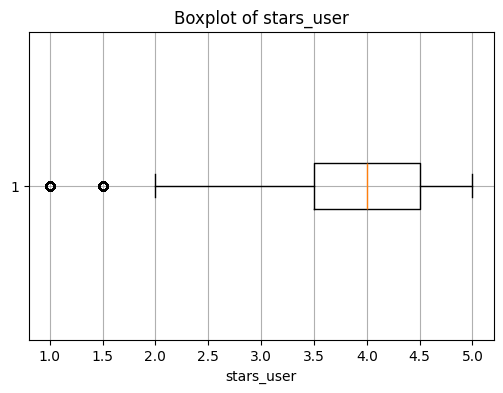

In [16]:
for col in cols_num:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df_drop_duplicates[col].dropna(), vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

### Check unnecessary columns

In [17]:
for col in cols_num:
    mean = df_drop_duplicates[col].mean()
    std = df_drop_duplicates[col].std()
    cv = std / mean if mean != 0 else 0
    print(f"{col}: std = {std:.2f}, mean = {mean:.2f}, CV = {cv:.2f}")

useful: std = 4.21, mean = 2.46, CV = 1.71
funny: std = 2.18, mean = 0.54, CV = 4.07
cool: std = 3.52, mean = 1.09, CV = 3.21
review_count: std = 471.05, mean = 168.65, CV = 2.79
useful_user: std = 4897.32, mean = 756.78, CV = 6.47
funny_user: std = 3215.00, mean = 309.54, CV = 10.39
cool_user: std = 4333.90, mean = 561.33, CV = 7.72
fans: std = 113.16, mean = 21.59, CV = 5.24
average_stars: std = 0.90, mean = 3.72, CV = 0.24
stars_user: std = 0.82, mean = 3.76, CV = 0.22


In [18]:
for col in cols_categoric + cols_string:
    print(f"{col}: {df_drop_duplicates[col].nunique()} unique values")

elite: 838 unique values
city: 1299 unique values
state: 24 unique values
review_id: 1499992 unique values
text: 1498155 unique values
address: 103378 unique values
categories: 70431 unique values


# Feature Engineering

In [19]:
df2 = df_drop_duplicates.copy()

## Aggregate

### Categorical Variables

In [20]:
cols_categoric.append("stars")
df2[cols_categoric] = df2[cols_categoric].astype("category")

In [21]:
cols_categoric

['elite', 'city', 'state', 'stars']

#### Elite

In [22]:
def fix_elite_format(val):
    if pd.isna(val) or val == "None":
        return None

    years = {
        "20" + y if len(y) == 2 and y.isdigit() else y.strip() for y in val.split(",")
    }
    return ",".join(sorted(years))

In [23]:
df2["elite"] = df2["elite"].apply(fix_elite_format)

In [24]:
df2["elite_count"] = (
    df2["elite"]
    .fillna("")
    .apply(lambda x: 0 if x in ["None", ""] else len(x.split(",")))
)

#### City

In [25]:
city_freq = df2["city"].value_counts(normalize=True)
df2["city_freq"] = df2["city"].map(city_freq)

#### State

In [26]:
state_freq = df2["state"].value_counts(normalize=True)
df2["state_freq"] = df2["state"].map(state_freq)

#### Pipeline

- EliteAggregateTransformer

In [27]:
class EliteAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def fix_elite(val):
            if pd.isna(val) or val == "None":
                return ""
            years = {
                "20" + y if len(y) == 2 and y.isdigit() else y.strip()
                for y in val.split(",")
            }
            return ",".join(sorted(years))

        X["elite"] = X["elite"].apply(fix_elite)
        X["elite_count"] = (
            X["elite"]
            .apply(lambda x: 0 if x == "" else len(x.split(",")))
            .astype("int32")
        )
        return X

- FrequencyEncodeAggregateTransformer

In [28]:
class FrequencyEncodeAggregateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.freq_maps = {}

    def fit(self, X, y=None):
        for col in self.columns:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[f"{col}_freq"] = X[col].map(self.freq_maps[col]).astype("float64")
        return X

- Pipeline

In [29]:
categorical_aggregate_pipe = Pipeline(
    steps=[
        ("elite_agg", EliteAggregateTransformer()),
        (
            "freq_encode_agg",
            FrequencyEncodeAggregateTransformer(columns=["city", "state"]),
        ),
    ]
)

### Numerical Variables

In [30]:
cols_num

['useful',
 'funny',
 'cool',
 'review_count',
 'useful_user',
 'funny_user',
 'cool_user',
 'fans',
 'average_stars',
 'stars_user']

#### Useful

In [31]:
df2["is_useful"] = df2["useful"] > 0

#### Funny

In [32]:
df2["is_funny"] = df2["funny"] > 0

#### Cool

In [33]:
df2["is_cool"] = df2["cool"] > 0

#### Review Count

In [34]:
df2["reviewer_level"] = pd.qcut(df2["review_count"], q=4, labels=[0, 1, 2, 3])

#### Useful User

In [35]:
df2["useful_user_level"] = pd.qcut(df2["useful_user"], q=4, labels=[0, 1, 2, 3])

#### Funny User

In [36]:
df2["funny_user_level"] = pd.qcut(df2["funny_user"], q=4, labels=[0, 1, 2, 3])

#### Cool User

In [37]:
df2["cool_user_level"] = pd.qcut(df2["cool_user"], q=4, labels=[0, 1, 2, 3])

#### Fans

In [38]:
p90 = df2["fans"][df2["fans"] > 0].quantile(0.90)


def map_fans_level(x):
    if x == 0:
        return 0
    elif x <= p90:
        return 1
    else:
        return 2


df2["fans_level"] = df2["fans"].apply(map_fans_level)

#### Pipeline

- BinaryFlagAggregateTransformer

In [39]:
class BinaryFlagAggregateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[f"is_{col}"] = (X[col] > 0).astype(bool)
        return X

- QCutLevelAggregateTransformer

In [40]:
class QCutLevelAggregateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, labels=[0, 1, 2, 3]):
        self.columns = columns
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[f"{col}_level"] = pd.qcut(
                X[col], q=4, labels=self.labels, duplicates="drop"
            ).astype("int32")
        return X

- FansLevelAggregateTransformer

In [41]:
class FansLevelAggregateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.p90 = X["fans"][X["fans"] > 0].quantile(0.90)
        return self

    def transform(self, X):
        X = X.copy()

        def map_fans_level(x):
            if x == 0:
                return 0
            elif x <= self.p90:
                return 1
            else:
                return 2

        X["fans_level"] = X["fans"].apply(map_fans_level).astype("int32")
        return X

- Pipeline

In [42]:
numerical_aggregate_pipe = Pipeline(
    steps=[
        (
            "binary_flags_agg",
            BinaryFlagAggregateTransformer(columns=["useful", "funny", "cool"]),
        ),
        (
            "qcut_levels_agg",
            QCutLevelAggregateTransformer(
                columns=["review_count", "useful_user", "funny_user", "cool_user"]
            ),
        ),
        ("fans_level_agg", FansLevelAggregateTransformer()),
    ]
)

### String Variables

### Data Variables

### Aggregate Pipeline

In [43]:
aggregate_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_agg", categorical_aggregate_pipe, ["elite", "city", "state"]),
        (
            "num_agg",
            numerical_aggregate_pipe,
            [
                "useful",
                "funny",
                "cool",
                "review_count",
                "useful_user",
                "funny_user",
                "cool_user",
                "fans",
            ],
        ),
    ]
)

## Compress

In [44]:
# df2 = df_drop_duplicates.drop(columns=["review_id"])

## Model-Independent Transformation